# Income classification

The main objective of this analysis is to provide insight on the data around income and accompanying features. Moreover, several models will be built, tuned and confronted to emerge the best of them in terms of accuracy of prediction.

In [263]:
#Importing necessary packages
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, classification_report
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import winsound 
import datetime
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import LinearSVC
import dill
from imblearn.over_sampling import SMOTE
from matplotlib.pyplot import figure
from sklearn.inspection import permutation_importance

## Preprocessing

The dataset consists of 15 features. They are both demographic (like age, sex), social (marital status, relationship) and economical (capital gain, loss). Variable "income" is binary and describes wether the person achieved income over $50k or below.

The data will be cleaned, NAs will be dropped, redundant variables will be dropped, data types will be aligned. After that, categorical variables will be encoded. If models require, the features will be scaled. After cleaning, train and test sets will be created.

In [264]:
train_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
colnames = ["age","workclass","fnlwgt","education","education_num","marital_status","occupation","relationship","race","sex","capital_gain","capital_loss","hours_per_week","native_country","income"]
train = pd.read_csv(train_url, names = colnames)
test = pd.read_csv(test_url, names = colnames)
df = pd.concat([train,test])

In [265]:
df.shape

(48843, 15)

In [266]:
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [267]:
print(df.isna().sum())
#one missing value in almost each column

age               0
workclass         1
fnlwgt            1
education         1
education_num     1
marital_status    1
occupation        1
relationship      1
race              1
sex               1
capital_gain      1
capital_loss      1
hours_per_week    1
native_country    1
income            1
dtype: int64


In [268]:
df.dropna(inplace=True)

In [269]:
df.info()
#age needs to be converted to numeric, 
#education can be dropped as its repeated in education_numeric,
#capital gain and loss can be combined to capital revenue
#relationship - has categories "husband" and "wife" - can be changed to "married", there is other var "sex"
#martial_status - distinction between spouse absent and spouse armed forces does not bring much information 
#as they contribute to a little over 1% of data - hence, marriage types will be combined to "Married"

<class 'pandas.core.frame.DataFrame'>
Index: 48842 entries, 0 to 16281
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             48842 non-null  object 
 1   workclass       48842 non-null  object 
 2   fnlwgt          48842 non-null  float64
 3   education       48842 non-null  object 
 4   education_num   48842 non-null  float64
 5   marital_status  48842 non-null  object 
 6   occupation      48842 non-null  object 
 7   relationship    48842 non-null  object 
 8   race            48842 non-null  object 
 9   sex             48842 non-null  object 
 10  capital_gain    48842 non-null  float64
 11  capital_loss    48842 non-null  float64
 12  hours_per_week  48842 non-null  float64
 13  native_country  48842 non-null  object 
 14  income          48842 non-null  object 
dtypes: float64(5), object(10)
memory usage: 6.0+ MB


In [270]:
df.describe()

,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [271]:
df['age'] = pd.to_numeric(df['age'], errors='coerce')

In [272]:
df = df.drop('education', axis=1)

In [273]:
df.value_counts()
#there is " ?" category in some variables, as well as target value has incorrect values "<=50K" 
#and "<=50K."
#there is several columns where string values start with spaces - they need to be stripped

age  workclass          fnlwgt    education_num  marital_status       occupation          relationship    race    sex      capital_gain  capital_loss  hours_per_week  native_country  income 
25    Private           195994.0  2.0             Never-married        Priv-house-serv     Not-in-family   White   Female  0.0           0.0           40.0             Guatemala       <=50K     3
29    Private           36440.0   13.0            Never-married        Adm-clerical        Not-in-family   White   Female  0.0           0.0           40.0             United-States   <=50K.    2
19    Private           146679.0  10.0            Never-married        Exec-managerial     Own-child       Black   Male    0.0           0.0           30.0             United-States   <=50K     2
42    Private           204235.0  10.0            Married-civ-spouse   Prof-specialty      Husband         White   Male    0.0           0.0           40.0             United-States   >50K      2
49    Self-emp-not-inc  4

In [274]:
for col in df.columns:
    if df[col].dtype == 'object':
     df[col] = df[col].str.lstrip()

In [275]:
(df == "?").sum()
# "?" - category in workclass

age                  0
workclass         2799
fnlwgt               0
education_num        0
marital_status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     857
income               0
dtype: int64

In [276]:
df = df[df["occupation"] != "?"]

In [277]:
(df == "?").sum()

age                 0
workclass           0
fnlwgt              0
education_num       0
marital_status      0
occupation          0
relationship        0
race                0
sex                 0
capital_gain        0
capital_loss        0
hours_per_week      0
native_country    811
income              0
dtype: int64

In [278]:
df = df[df["native_country"] != "?"]

In [279]:
(df == "?").sum()

age               0
workclass         0
fnlwgt            0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

In [280]:
df["capital_rev"] = df['capital_gain'] - df['capital_loss']
df = df.drop(['capital_gain' , 'capital_loss'], axis=1)

In [281]:
df['relationship'] = df['relationship'].replace({'Husband': 'Married', 'Wife': 'Married'})
df['relationship'].value_counts()

relationship
Married           20757
Not-in-family     11702
Own-child          6626
Unmarried          4788
Other-relative     1349
Name: count, dtype: int64

In [282]:
df['income'] = df['income'].replace({'<=50K.': '<=50K', '>50K.': '>50K'})
df['income'].value_counts()

income
<=50K    34014
>50K     11208
Name: count, dtype: int64

In [283]:
df['workclass'].value_counts()

workclass
Private             33307
Self-emp-not-inc     3796
Local-gov            3100
State-gov            1946
Self-emp-inc         1646
Federal-gov          1406
Without-pay            21
Name: count, dtype: int64

In [284]:
df['marital_status'] = df['marital_status'].replace({'Married-civ-spouse': 'Married',
                                                     'Married-spouse-absent': 'Married',
                                                     'Married-AF-spouse': 'Married'})
df['marital_status'].value_counts()

marital_status
Married          21639
Never-married    14598
Divorced          6297
Separated         1411
Widowed           1277
Name: count, dtype: int64

In [285]:
df['occupation'].value_counts()

occupation
Craft-repair         6020
Prof-specialty       6008
Exec-managerial      5984
Adm-clerical         5540
Sales                5408
Other-service        4808
Machine-op-inspct    2970
Transport-moving     2316
Handlers-cleaners    2046
Farming-fishing      1480
Tech-support         1420
Protective-serv       976
Priv-house-serv       232
Armed-Forces           14
Name: count, dtype: int64

In [286]:
df['race'].value_counts()

race
White                 38903
Black                  4228
Asian-Pac-Islander     1303
Amer-Indian-Eskimo      435
Other                   353
Name: count, dtype: int64

In [287]:
df['sex'].value_counts()

sex
Male      30527
Female    14695
Name: count, dtype: int64

In [288]:
df['education_num'] = df['education_num'].astype('int')
df['fnlwgt'] = df['fnlwgt'].astype('int')
df['hours_per_week'] = df['hours_per_week'].astype('int')

In [289]:
df['native_country'].value_counts(normalize=True)

native_country
United-States                 0.913095
Mexico                        0.019968
Philippines                   0.006258
Germany                       0.004268
Puerto-Rico                   0.003870
Canada                        0.003604
El-Salvador                   0.003251
India                         0.003251
Cuba                          0.002941
England                       0.002631
China                         0.002499
Jamaica                       0.002278
South                         0.002233
Italy                         0.002211
Dominican-Republic            0.002145
Japan                         0.001968
Guatemala                     0.001902
Vietnam                       0.001835
Columbia                      0.001813
Poland                        0.001791
Haiti                         0.001526
Portugal                      0.001371
Iran                          0.001238
Taiwan                        0.001216
Greece                        0.001084
Nicaragua 

In [290]:
df.shape

(45222, 13)

In [291]:
df = df.drop_duplicates()
df.shape

(45175, 13)

In [292]:
df['income'].value_counts(normalize = True)
# 3:1 proportion of target variable, to be determined if resampling is needed after checking accuracy

income
<=50K    0.752031
>50K     0.247969
Name: proportion, dtype: float64

## Exploration

In [293]:
nums = ['age','fnlwgt','hours_per_week','capital_rev']
nums = df[nums]
cats = df.drop(columns=nums)
cats = cats.drop(columns="native_country")
print(len(nums.columns),",", len(cats.columns))

4 , 8


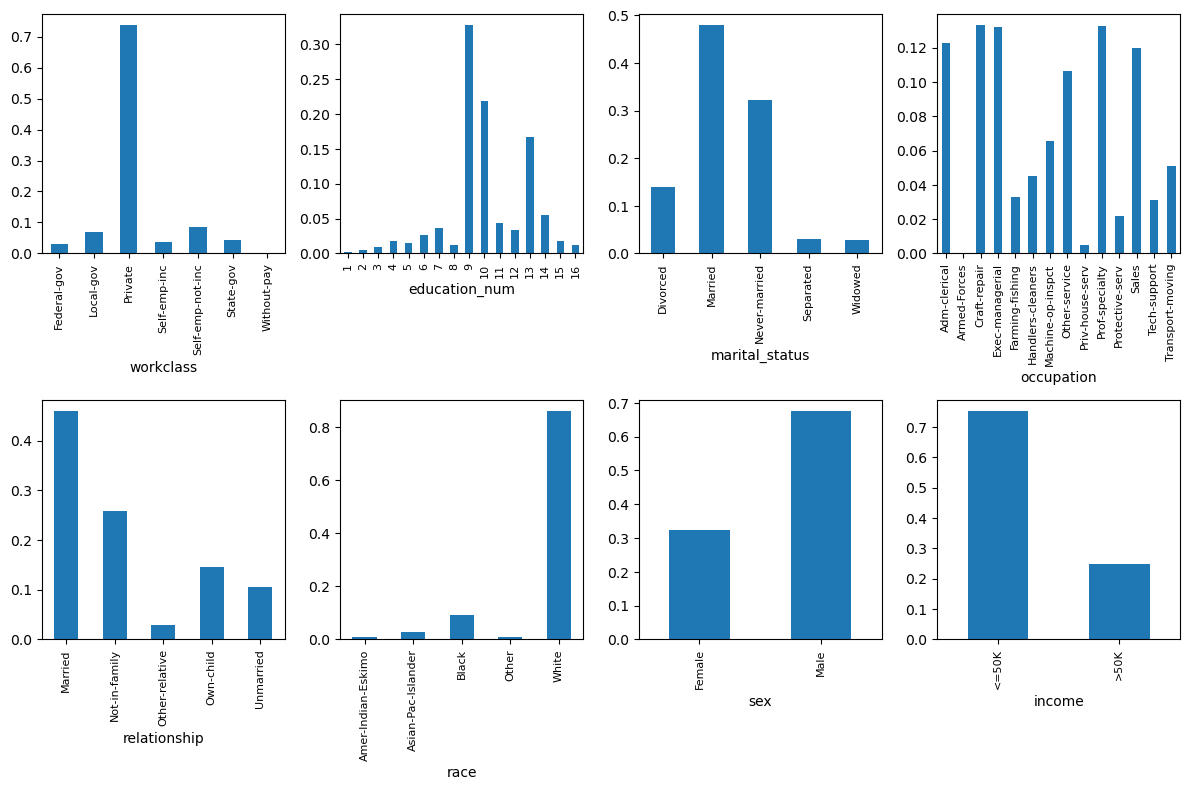

In [294]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(cats.columns):
    cats[col].value_counts(normalize=True).sort_index().plot(kind='bar', ax=axes[i])
    axes[i].tick_params(axis='x', labelsize=8)
    
plt.tight_layout()
plt.show()

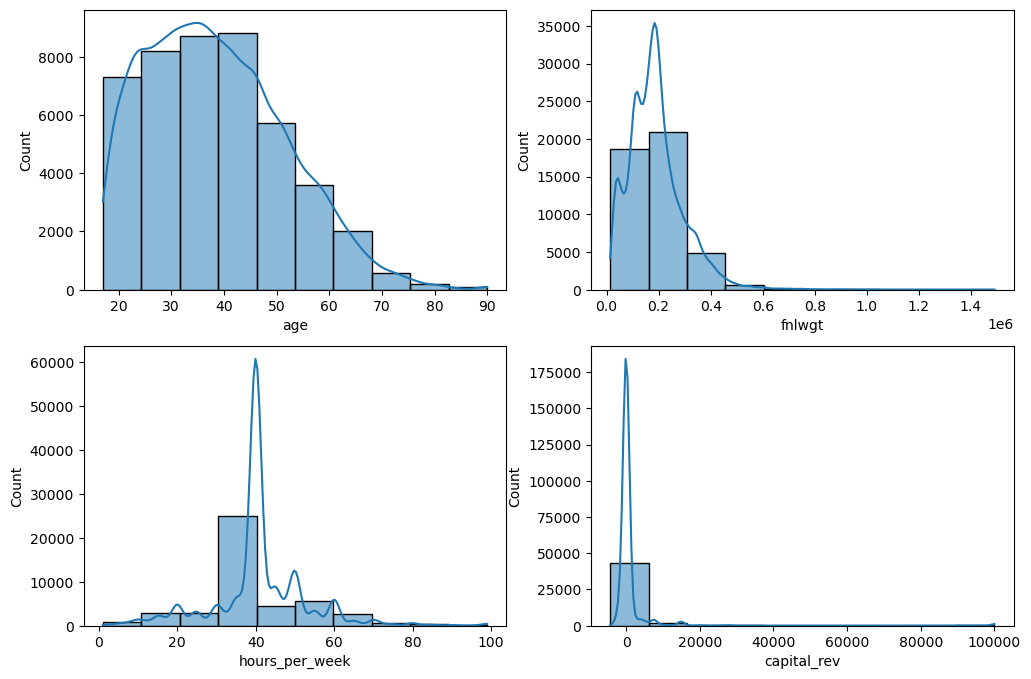

In [295]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(nums.columns):
    sns.histplot(nums[col], bins=10, kde=True, ax=axes[i])
    #axes[i].set_title(col)

plt.show()

## Variable recoding and train/test split

In [296]:
le = LabelEncoder()
for col in df.columns:
    if df[col].dtype == object:
        df[col] = le.fit_transform(df[col])

In [297]:
X = df.drop('income', axis=1)
y = df['income']

In [298]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 7)

## Helper functions definition

In [299]:
metrics = pd.DataFrame(columns=['model','accuracy','precision','recall','f1','auc'])
roc_params = pd.DataFrame(columns=['model','tpr','fpr','auc'])
#placeholder dataframes for prediction metrics and statistics for ROC curve plotting

In [300]:
def get_prediction(model_fit, test_set, model_name):
    global metrics, y_test
    y_pred = model_fit.predict(test_set)
    accuracy = accuracy_score(y_test, y_pred)
    scores = score(y_test, y_pred, average = 'weighted')
    auc =  roc_auc_score(y_test, y_pred)
    mm = pd.DataFrame({'model': [f"{model_name}"],
                       'accuracy' : [accuracy],
                       'precision': [scores[0]],
                       'recall' : [scores[1]],
                       'f1' : [scores[2]],
                       'auc' : [auc]})
    metrics = pd.concat([metrics, mm])

In [301]:
def get_roc_params(model_fit,  test_set, model_name):
    global roc_params, y_test
    y_pred = model_fit.predict(test_set)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc =  roc_auc_score(y_test, y_pred)
    rp =  pd.DataFrame({'model': [f"{model_name}"],
                       'tpr' : [tpr],
                       'fpr': [fpr],
                       'auc' : [auc]})
    roc_params = pd.concat([roc_params, rp])

## Logistic Regression

In [302]:
lr = LogisticRegression(random_state=777, solver='liblinear').fit(X_train, y_train.values.ravel())
print(accuracy_score(y_test, lr.predict(X_test)))

0.7936912008854455


In [303]:
lr_param_grid= {'C': [0.0001, 0.01, 0.1, 1, 10, 100],  
                'penalty': ['l1', 'l2'],               
                'max_iter': [100, 1000, 10000]}

In [304]:
lr_grid_search = GridSearchCV(lr, lr_param_grid, cv=5)
lr_grid_search.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=777, solver='liblinear'),
             param_grid={'C': [0.0001, 0.01, 0.1, 1, 10, 100],
                         'max_iter': [100, 1000, 10000],
                         'penalty': ['l1', 'l2']})

In [305]:
lr_gs_results = pd.DataFrame(lr_grid_search.cv_results_)
lr_gs_results = lr_gs_results[['param_C','param_max_iter','param_penalty',
                               'mean_test_score','rank_test_score']].sort_values(by='rank_test_score')
lr_gs_results

,param_C,param_max_iter,param_penalty,mean_test_score,rank_test_score
16,0.1,10000,l1,0.828832,1
14,0.1,1000,l1,0.828832,1
12,0.1,100,l1,0.828832,1
22,1,10000,l1,0.828390,4
18,1,100,l1,0.828390,4
32,100,1000,l1,0.828390,4
34,100,10000,l1,0.828390,4
30,100,100,l1,0.828390,4
24,10,100,l1,0.828390,4
28,10,10000,l1,0.828390,4


In [314]:
print(lr_grid_search.best_params_)
lr = lr_grid_search.best_estimator_

{'C': 0.1, 'max_iter': 100, 'penalty': 'l1'}


In [311]:
get_prediction(lr, X_test, "Logistic Regression")
metrics

,model,accuracy,precision,recall,f1,auc
0,Logistic Regression,0.828224,0.818752,0.828224,0.819121,0.726891


In [312]:
get_roc_params(lr, X_test, "Logistic Regression")
roc_params

,model,tpr,fpr,auc
0,Logistic Regression,"[0.0, 0.5258928571428572, 1.0]","[0.0, 0.07211184694628403, 1.0]",0.726891


## Decision Trees

In [315]:
dt = DecisionTreeClassifier(random_state=777)
dt = dt.fit(X_train, y_train)
print(accuracy_score(y_test, dt.predict(X_test)))

0.8076369673491975


In [316]:
dt_param_grid = {'max_depth':range(1, dt.tree_.max_depth+1, 2),
              'max_features': range(1, len(dt.feature_importances_)+1),
              'ccp_alpha': np.arange(0, 0.04, 0.005)}

In [317]:
dt_grid_search = GridSearchCV(dt, param_grid = dt_param_grid, scoring='accuracy', n_jobs=-1)
dt_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=777), n_jobs=-1,
             param_grid={'ccp_alpha': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035]),
                         'max_depth': range(1, 51, 2),
                         'max_features': range(1, 13)},
             scoring='accuracy')

In [318]:
dt_grid_search.best_params_

{'ccp_alpha': 0.0, 'max_depth': 9, 'max_features': 8}

In [319]:
dt_gs_results = pd.DataFrame(dt_grid_search.cv_results_)
dt_gs_results = dt_gs_results[['param_ccp_alpha','param_max_depth','param_max_features',
                               'mean_test_score','rank_test_score']].sort_values(by='rank_test_score')
dt_gs_results.sort_values(by='rank_test_score')

,param_ccp_alpha,param_max_depth,param_max_features,mean_test_score,rank_test_score
55,0.0,9,8,0.853403,1
47,0.0,7,12,0.852020,2
46,0.0,7,11,0.851909,3
68,0.0,11,9,0.851716,4
45,0.0,7,10,0.851384,5
...,...,...,...,...,...
2192,0.035,15,9,0.752020,1589
2193,0.035,15,10,0.752020,1589
2194,0.035,15,11,0.752020,1589
304,0.005,1,5,0.752020,1589


In [320]:
print(dt_grid_search.best_params_)
dt = dt_grid_search.best_estimator_

{'ccp_alpha': 0.0, 'max_depth': 9, 'max_features': 8}


In [321]:
get_prediction(dt, X_test, "Decision Tree")
metrics

,model,accuracy,precision,recall,f1,auc
0,Logistic Regression,0.828224,0.818752,0.828224,0.819121,0.726891
0,Decision Tree,0.850249,0.843776,0.850249,0.841819,0.754252


In [322]:
get_roc_params(dt, X_test, "Decision Tree")
roc_params

,model,tpr,fpr,auc
0,Logistic Regression,"[0.0, 0.5258928571428572, 1.0]","[0.0, 0.07211184694628403, 1.0]",0.726891
0,Decision Tree,"[0.0, 0.5638392857142858, 1.0]","[0.0, 0.055334805003679176, 1.0]",0.754252


## K-Nearest Neighbors

In [54]:
ss = StandardScaler()
X_test_scaled = ss.fit_transform(X_test)
X_train_scaled = ss.fit_transform(X_train)

In [55]:
knn = KNeighborsClassifier(n_jobs=-1)
knn = knn.fit(X_train_scaled, y_train)
print(accuracy_score(y_test, knn.predict(X_test)))

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


0.7552850027670172


In [56]:
knn_param_grid = {'n_neighbors':range(1, 30),
                  'weights': ['uniform','distance'],
                  'p': [1, 2, 4]}
knn_grid_search = GridSearchCV(knn, param_grid = knn_param_grid, scoring='accuracy', n_jobs=-1)
knn_grid_search.fit(X_train_scaled, y_train)
knn_grid_search.best_params_

{'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}

In [57]:
knn_gs_results = pd.DataFrame(knn_grid_search.cv_results_)
knn_gs_results = knn_gs_results[['param_n_neighbors','param_p','param_weights',
                                 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score')
knn_gs_results
#uniform weights and p equal to 1 are the best for model, another grid for neighbors will be ran 

,param_n_neighbors,param_p,param_weights,mean_test_score,rank_test_score
144,25,1,uniform,0.837521,1
156,27,1,uniform,0.836829,2
168,29,1,uniform,0.836718,3
120,21,1,uniform,0.836608,4
132,23,1,uniform,0.836608,4
...,...,...,...,...,...
3,1,2,distance,0.790288,169
2,1,2,uniform,0.790288,169
11,2,4,distance,0.789485,172
5,1,4,distance,0.789485,172


In [58]:
knn = KNeighborsClassifier(weights='uniform', p = 1, n_jobs=-1)
knn_param_grid = {'n_neighbors':range(1, 30)}
knn_grid_search = GridSearchCV(knn, param_grid = knn_param_grid, scoring='accuracy', n_jobs=-1)
knn_grid_search.fit(X_train_scaled, y_train)

GridSearchCV(estimator=KNeighborsClassifier(n_jobs=-1, p=1), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 30)}, scoring='accuracy')

In [59]:
knn_gs_results = pd.DataFrame(knn_grid_search.cv_results_)
knn_gs_results = knn_gs_results[['param_n_neighbors',
                                 'mean_test_score','rank_test_score']].sort_values(by='param_n_neighbors')
knn_gs_results

,param_n_neighbors,mean_test_score,rank_test_score
0,1,0.791201,29
1,2,0.805811,28
2,3,0.815329,27
3,4,0.819203,26
4,5,0.824709,25
5,6,0.826563,24
6,7,0.831295,21
7,8,0.830105,22
8,9,0.831904,18
9,10,0.829718,23


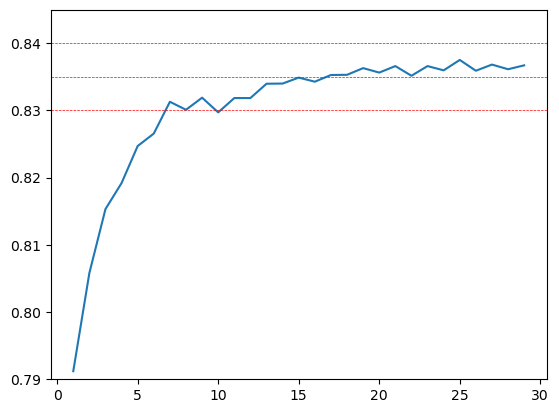

In [60]:
p = knn_gs_results['param_n_neighbors']
s = knn_gs_results['mean_test_score']
plt.plot(p,s)
plt.ylim(0.79,0.845)
plt.axhline(y=0.83, color='r', linestyle='--', linewidth=0.5)
plt.axhline(y=0.835, color='r', linestyle='--', linewidth=0.5)
plt.axhline(y=0.84, color='r', linestyle='--', linewidth=0.5)
#test score flattens at around 15, let's stick to that parameter

In [61]:
knn = knn_grid_search.best_estimator_

In [62]:
get_prediction(knn, X_test_scaled, "K Nearest Neighbors")
metrics

,model,accuracy,precision,recall,f1,auc
0,Logistic Regression,0.828224,0.818752,0.828224,0.819121,0.726891
0,Decision Tree,0.850249,0.843776,0.850249,0.841819,0.754252
0,K Nearest Neighbors,0.821583,0.815614,0.821583,0.817793,0.741479


In [63]:
get_roc_params(knn, X_test_scaled, "K Nearest Neighbors")
roc_params

,model,tpr,fpr,auc
0,Logistic Regression,"[0.0, 0.5258928571428572, 1.0]","[0.0, 0.07211184694628403, 1.0]",0.726891
0,Decision Tree,"[0.0, 0.5638392857142858, 1.0]","[0.0, 0.055334805003679176, 1.0]",0.754252
0,K Nearest Neighbors,"[0.0, 0.5825892857142857, 1.0]","[0.0, 0.09963208241353937, 1.0]",0.741479


## Boosting

In [64]:
xgb = XGBClassifier(objective='binary:logistic', n_jobs=-1, random_state=777)
xgb_param_grid = {'n_estimators': range(0, 501, 50),
                  'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]}
xgb_grid_search = GridSearchCV(xgb, param_grid = xgb_param_grid, scoring='accuracy', n_jobs=-1)
xgb_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=777, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25],
                         'n_estimators': range(0, 501, 50)},
             scoring='accuracy')

In [65]:
xgb_gs_results = pd.DataFrame(xgb_grid_search.cv_results_)
xgb_gs_results = xgb_gs_results[['param_n_estimators', 'param_learning_rate','mean_test_score',
                                 'rank_test_score']].sort_values(by='rank_test_score')
xgb_gs_results

,param_n_estimators,param_learning_rate,mean_test_score,rank_test_score
18,350,0.05,0.870753,1
17,300,0.05,0.870504,2
16,250,0.05,0.870504,3
26,200,0.1,0.870448,4
19,400,0.05,0.870255,5
...,...,...,...,...
22,0,0.1,0.752020,61
55,0,0.25,0.752020,61
11,0,0.05,0.752020,61
44,0,0.2,0.752020,61


In [66]:
print(xgb_grid_search.best_params_)
xgb = xgb_grid_search.best_estimator_

In [67]:
get_prediction(xgb, X_test, "XG Boost")
metrics

,model,accuracy,precision,recall,f1,auc
0,Logistic Regression,0.828224,0.818752,0.828224,0.819121,0.726891
0,Decision Tree,0.850249,0.843776,0.850249,0.841819,0.754252
0,K Nearest Neighbors,0.821583,0.815614,0.821583,0.817793,0.741479
0,XG Boost,0.871721,0.867502,0.871721,0.867834,0.801446


In [68]:
get_roc_params(xgb, X_test, "XG Boost")
roc_params

,model,tpr,fpr,auc
0,Logistic Regression,"[0.0, 0.5258928571428572, 1.0]","[0.0, 0.07211184694628403, 1.0]",0.726891
0,Decision Tree,"[0.0, 0.5638392857142858, 1.0]","[0.0, 0.055334805003679176, 1.0]",0.754252
0,K Nearest Neighbors,"[0.0, 0.5825892857142857, 1.0]","[0.0, 0.09963208241353937, 1.0]",0.741479
0,XG Boost,"[0.0, 0.6620535714285715, 1.0]","[0.0, 0.059161147902869755, 1.0]",0.801446


## Random Forest - Bagging

In [69]:
rf = RandomForestClassifier(max_depth=5, bootstrap = True, oob_score=True, n_jobs=-1, random_state = 777, 
                            warm_start=True, max_features = round(np.sqrt(len(X_train.columns)))-1)

In [70]:
rf_oob_list = list()

for n_trees in [15, 20, 30, 40, 50, 100, 110, 120, 130, 140, 150, 200, 300, 400]:
    rf.set_params(n_estimators=n_trees)
    rf.fit(X_train, y_train)
    rf_oob_list.append(pd.Series({'n_trees': n_trees, 'oob': rf.oob_score_}))

rf_oob_df = pd.concat(rf_oob_list, axis=1).T.set_index('n_trees')
rf_oob_df

#oob score peaked at 200 trees, then started shrinking

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


,oob
n_trees,
15.0,0.837714
20.0,0.836829
30.0,0.836746
40.0,0.838323
50.0,0.838129
100.0,0.841201
110.0,0.841201
120.0,0.841422
130.0,0.841422


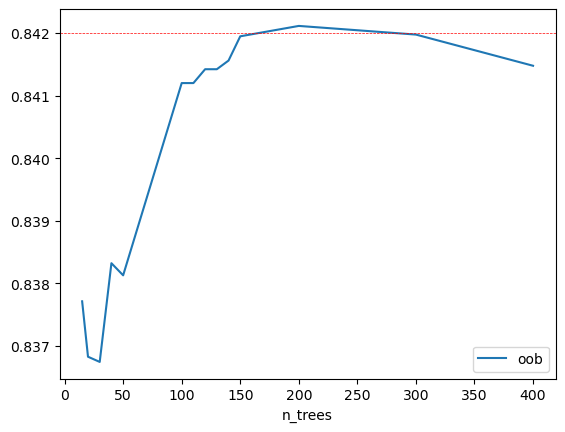

In [71]:
rf_oob_df.reset_index(inplace=True)
rf_oob_df.plot(y = 'oob', x = 'n_trees')
plt.axhline(y=0.842, color='r', linestyle='--', linewidth=0.5)

In [72]:
rf = RandomForestClassifier(bootstrap = True, oob_score=True, n_jobs=-1, 
                            random_state = 777, warm_start=True)
mfs = round(np.sqrt(len(X_train.columns))) #max features squared

In [73]:
rf_param_grid = {'n_estimators': [15, 20, 30, 40, 50, 100, 110, 120, 130, 140, 150, 200, 300, 400],
                  'max_features': [mfs-1, mfs, mfs+1],
                  'max_depth': range(3,8)}
rf_grid_search = GridSearchCV(rf, param_grid = rf_param_grid, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=777,
                                              warm_start=True),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 8), 'max_features': [2, 3, 4],
                         'n_estimators': [15, 20, 30, 40, 50, 100, 110, 120,
                                          130, 140, 150, 200, 300, 400]},
             scoring='accuracy')

In [74]:
rf_grid_search.best_params_

{'max_depth': 7, 'max_features': 4, 'n_estimators': 110}

In [75]:
rf_gs_results = pd.DataFrame(rf_grid_search.cv_results_)
rf_gs_results = rf_gs_results[['param_n_estimators','param_max_features','param_max_depth',
                                 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score')
                                                                                   
rf_gs_results

,param_n_estimators,param_max_features,param_max_depth,mean_test_score,rank_test_score
202,110,4,7,0.851300,1
200,50,4,7,0.851245,2
209,400,4,7,0.851190,3
203,120,4,7,0.851190,3
201,100,4,7,0.851162,5
...,...,...,...,...,...
5,100,2,3,0.807692,206
6,110,2,3,0.805977,207
1,20,2,3,0.805672,208
4,50,2,3,0.804898,209


In [76]:
bps = rf_gs_results[(rf_gs_results['param_max_features'] == 4) & (rf_gs_results['param_max_depth'] == 7)]
#best params set

C:\Users\apobi\AppData\Local\Temp\ipykernel_10916\2936699219.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bps.sort_values(by='param_n_estimators', inplace=True)


<Axes: xlabel='param_n_estimators'>

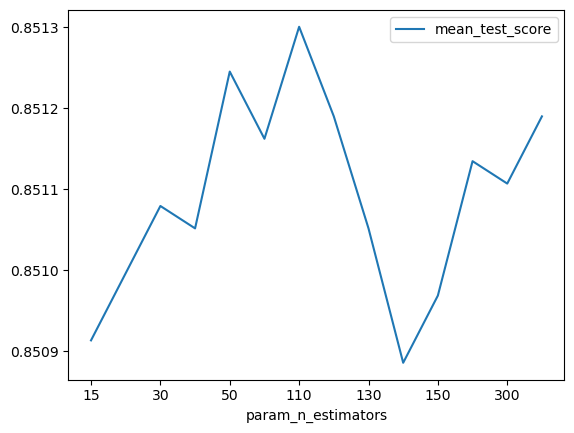

In [77]:
bps.sort_values(by='param_n_estimators', inplace=True)
bps.plot('param_n_estimators', 'mean_test_score')

In [78]:
print(rf_grid_search.best_params_)
rf = rf_grid_search.best_estimator_

In [79]:
get_prediction(rf, X_test, "Random Forest")
metrics

,model,accuracy,precision,recall,f1,auc
0,Logistic Regression,0.828224,0.818752,0.828224,0.819121,0.726891
0,Decision Tree,0.850249,0.843776,0.850249,0.841819,0.754252
0,K Nearest Neighbors,0.821583,0.815614,0.821583,0.817793,0.741479
0,XG Boost,0.871721,0.867502,0.871721,0.867834,0.801446
0,Random Forest,0.852131,0.846419,0.852131,0.842495,0.751164


In [80]:
get_roc_params(rf, X_test, "Random Forest")
roc_params

,model,tpr,fpr,auc
0,Logistic Regression,"[0.0, 0.5258928571428572, 1.0]","[0.0, 0.07211184694628403, 1.0]",0.726891
0,Decision Tree,"[0.0, 0.5638392857142858, 1.0]","[0.0, 0.055334805003679176, 1.0]",0.754252
0,K Nearest Neighbors,"[0.0, 0.5825892857142857, 1.0]","[0.0, 0.09963208241353937, 1.0]",0.741479
0,XG Boost,"[0.0, 0.6620535714285715, 1.0]","[0.0, 0.059161147902869755, 1.0]",0.801446
0,Random Forest,"[0.0, 0.5508928571428572, 1.0]","[0.0, 0.04856512141280353, 1.0]",0.751164


## Oversampling approach

In [81]:
y.value_counts(normalize=True)
#The target variable balance is around 3:1
#Lets do oversampling and check if the best models anyhow perform better

income
0    0.752031
1    0.247969
Name: proportion, dtype: float64

In [82]:
smote_sampler = SMOTE(random_state = 777)
X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)
y_smo.value_counts(normalize=True)

income
0    0.5
1    0.5
Name: proportion, dtype: float64

In [83]:
ss = StandardScaler()
X_smo_train_scaled = ss.fit_transform(X_smo)

In [84]:
lr_smot = lr.fit(X_smo, y_smo)
dt_smot = dt.fit(X_smo, y_smo)
knn_smot = knn.fit(X_smo_train_scaled, y_smo)
xgb_smot = xgb.fit(X_smo, y_smo)
rf_smot = rf.fit(X_smo, y_smo)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:435: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


In [85]:
models =  [lr_smot, dt_smot, xgb_smot, rf_smot]

for model in models:
    get_prediction(model, X_test, f"Oversampling - {model}")
    get_roc_params(model, X_test, f"Oversampling - {model}")

knn.fit(X_smo_train_scaled, y_smo)
get_prediction(knn, X_test_scaled, "Oversampling  - K Nearest Neighbors")
get_roc_params(knn, X_test_scaled, "Oversampling - K Nearest Neighbors")

In [86]:
metrics.sort_values(by="accuracy", ascending=False, inplace = True)
#Oversampling didnt bring better results in accuracy than not-rebalanced models
#Each oversampled model performs worse than its not-rebalanced counterpart
#Maybe other oversampling technique would bring other results
metrics

,model,accuracy,precision,recall,f1,auc
0,XG Boost,0.871721,0.867502,0.871721,0.867834,0.801446
0,Random Forest,0.852131,0.846419,0.852131,0.842495,0.751164
0,Oversampling - RandomForestClassifier(max_dept...,0.852131,0.846419,0.852131,0.842495,0.751164
0,Decision Tree,0.850249,0.843776,0.850249,0.841819,0.754252
0,"Oversampling - XGBClassifier(base_score=None, ...",0.847925,0.858006,0.847925,0.851494,0.822884
0,Logistic Regression,0.828224,0.818752,0.828224,0.819121,0.726891
0,K Nearest Neighbors,0.821583,0.815614,0.821583,0.817793,0.741479
0,Oversampling - DecisionTreeClassifier(ccp_alph...,0.821251,0.840848,0.821251,0.827502,0.803654
0,"Oversampling - LogisticRegression(C=0.1, penal...",0.775650,0.833689,0.775650,0.789009,0.796381
0,Oversampling - K Nearest Neighbors,0.757056,0.816765,0.757056,0.771565,0.772048


In [87]:
oversampled = metrics['model'].str.contains('Oversampling')
metrics = metrics[~oversampled]
metrics

,model,accuracy,precision,recall,f1,auc
0,XG Boost,0.871721,0.867502,0.871721,0.867834,0.801446
0,Random Forest,0.852131,0.846419,0.852131,0.842495,0.751164
0,Decision Tree,0.850249,0.843776,0.850249,0.841819,0.754252
0,Logistic Regression,0.828224,0.818752,0.828224,0.819121,0.726891
0,K Nearest Neighbors,0.821583,0.815614,0.821583,0.817793,0.741479


In [88]:
roc_params.sort_values(by='auc', ascending=False)
#not suprisingly - the models got better in detecting positive cases - tpr rose, but in a trade off they
#became worse in fpr - it rose as well
#these findings are significant if there was a bigger emphasis on predicting one of the classes
#overall - each oversampled model performed better than its counterpart if we picked AUC as criterion
#in this case - we are intereseted more in overall accuracy so we will stick to previous results

,model,tpr,fpr,auc
0,"Oversampling - XGBClassifier(base_score=None, ...","[0.0, 0.7732142857142857, 1.0]","[0.0, 0.1274466519499632, 1.0]",0.822884
0,Oversampling - DecisionTreeClassifier(ccp_alph...,"[0.0, 0.76875, 1.0]","[0.0, 0.16144223693892568, 1.0]",0.803654
0,XG Boost,"[0.0, 0.6620535714285715, 1.0]","[0.0, 0.059161147902869755, 1.0]",0.801446
0,"Oversampling - LogisticRegression(C=0.1, penal...","[0.0, 0.8375, 1.0]","[0.0, 0.24473877851361295, 1.0]",0.796381
0,Oversampling - K Nearest Neighbors,"[0.0, 0.8017857142857143, 1.0]","[0.0, 0.2576894775570272, 1.0]",0.772048
0,Decision Tree,"[0.0, 0.5638392857142858, 1.0]","[0.0, 0.055334805003679176, 1.0]",0.754252
0,Random Forest,"[0.0, 0.5508928571428572, 1.0]","[0.0, 0.04856512141280353, 1.0]",0.751164
0,Oversampling - RandomForestClassifier(max_dept...,"[0.0, 0.5508928571428572, 1.0]","[0.0, 0.04856512141280353, 1.0]",0.751164
0,K Nearest Neighbors,"[0.0, 0.5825892857142857, 1.0]","[0.0, 0.09963208241353937, 1.0]",0.741479
0,Logistic Regression,"[0.0, 0.5258928571428572, 1.0]","[0.0, 0.07211184694628403, 1.0]",0.726891


In [89]:
oversampled = roc_params['model'].str.contains('Oversampling')
roc_params = roc_params[~oversampled]
roc_params.sort_values(by='auc', ascending=False, inplace=True)
roc_params

,model,tpr,fpr,auc
0,XG Boost,"[0.0, 0.6620535714285715, 1.0]","[0.0, 0.059161147902869755, 1.0]",0.801446
0,Decision Tree,"[0.0, 0.5638392857142858, 1.0]","[0.0, 0.055334805003679176, 1.0]",0.754252
0,Random Forest,"[0.0, 0.5508928571428572, 1.0]","[0.0, 0.04856512141280353, 1.0]",0.751164
0,K Nearest Neighbors,"[0.0, 0.5825892857142857, 1.0]","[0.0, 0.09963208241353937, 1.0]",0.741479
0,Logistic Regression,"[0.0, 0.5258928571428572, 1.0]","[0.0, 0.07211184694628403, 1.0]",0.726891


## Feature importances

In [90]:
def visualize_feature_importance(importance_array, model_name):
    sorted_idx = importance_array.importances_mean.argsort()
    fig, ax = plt.subplots()
    fig.set_figwidth(16)
    fig.set_figheight(10)
    fig.tight_layout()
    ax.boxplot(importance_array.importances[sorted_idx].T,
               vert=False, labels=X_train.columns[sorted_idx])
    ax.set_title(f'Permutation Importances - {model_name}')
    plt.show()

In [91]:
lr_fi = permutation_importance(estimator=lr, X = X_train, y = y_train, n_repeats=5,
                                random_state=777, n_jobs=-1)
dt_fi = permutation_importance(estimator=dt, X = X_train, y = y_train, n_repeats=5,
                                random_state=777, n_jobs=-1)
knn_fi = permutation_importance(estimator=knn, X = X_train_scaled, y = y_train, n_repeats=5,
                                random_state=777, n_jobs=-1)
xgb_fi = permutation_importance(estimator=xgb, X = X_train, y = y_train, n_repeats=5,
                                random_state=777, n_jobs=-1)
rf_fi = permutation_importance(estimator=rf, X = X_train, y = y_train, n_repeats=5,
                                random_state=777, n_jobs=-1)

In [92]:
lr_fi.importances_mean.argsort()

array([ 4,  7,  5, 10,  2,  8,  9,  0,  1, 11,  3,  6], dtype=int64)

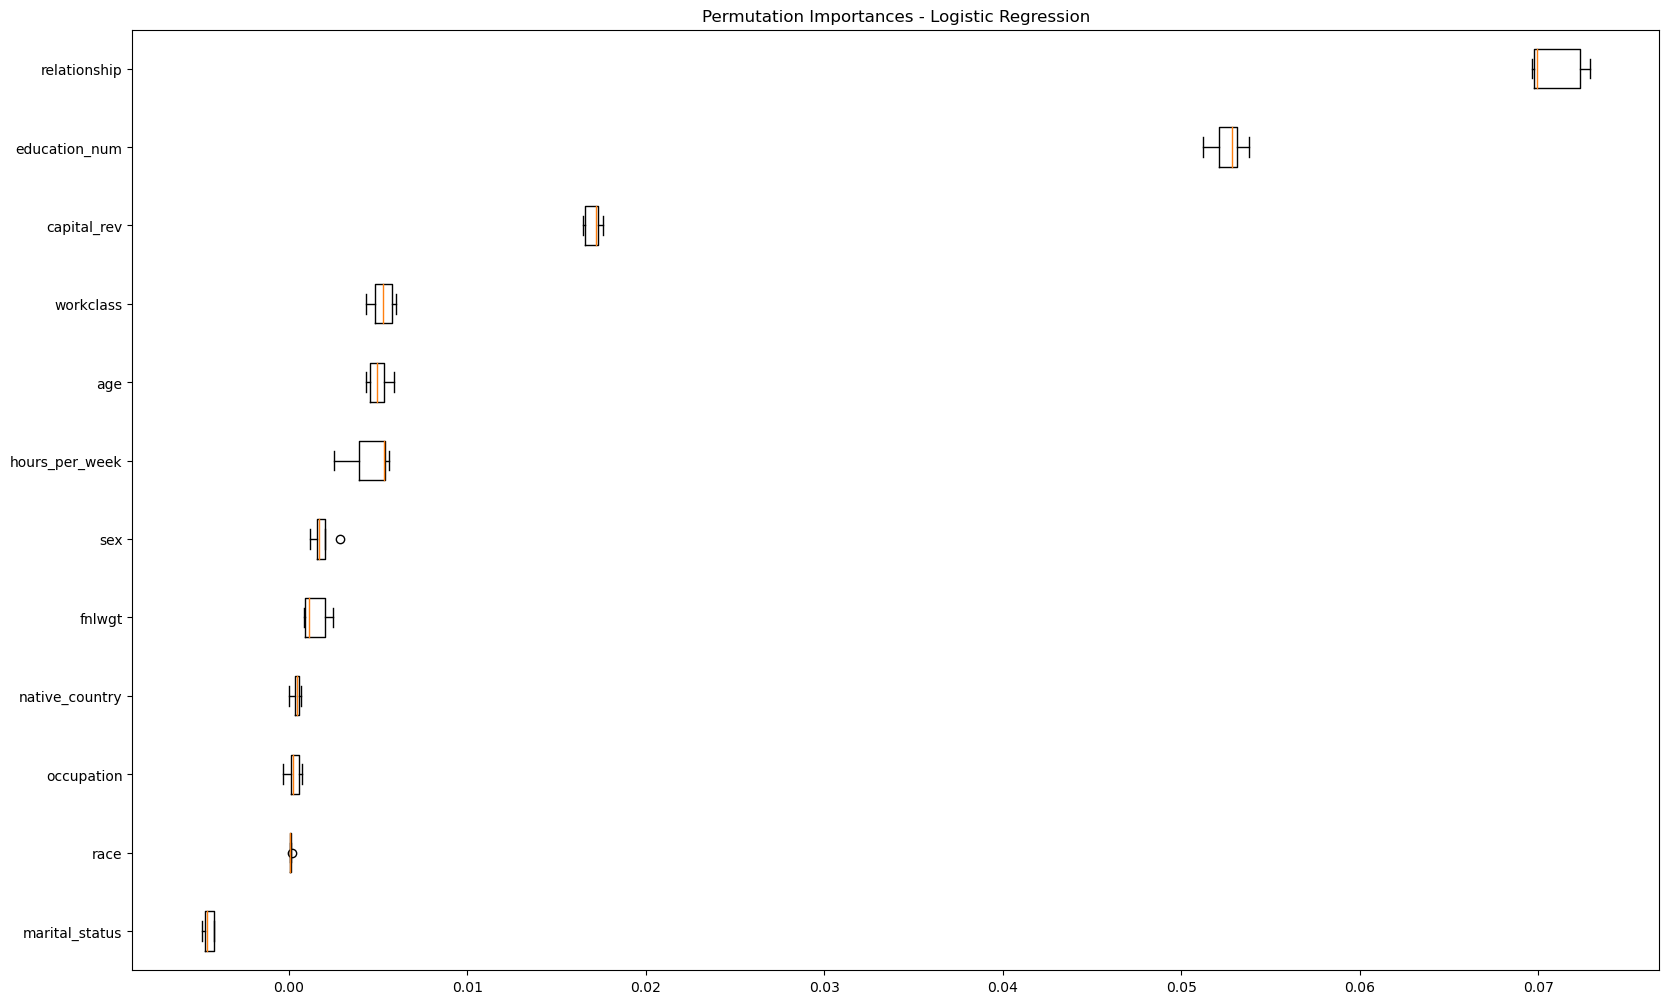

In [93]:
visualize_feature_importance(lr_fi,"Logistic Regression")

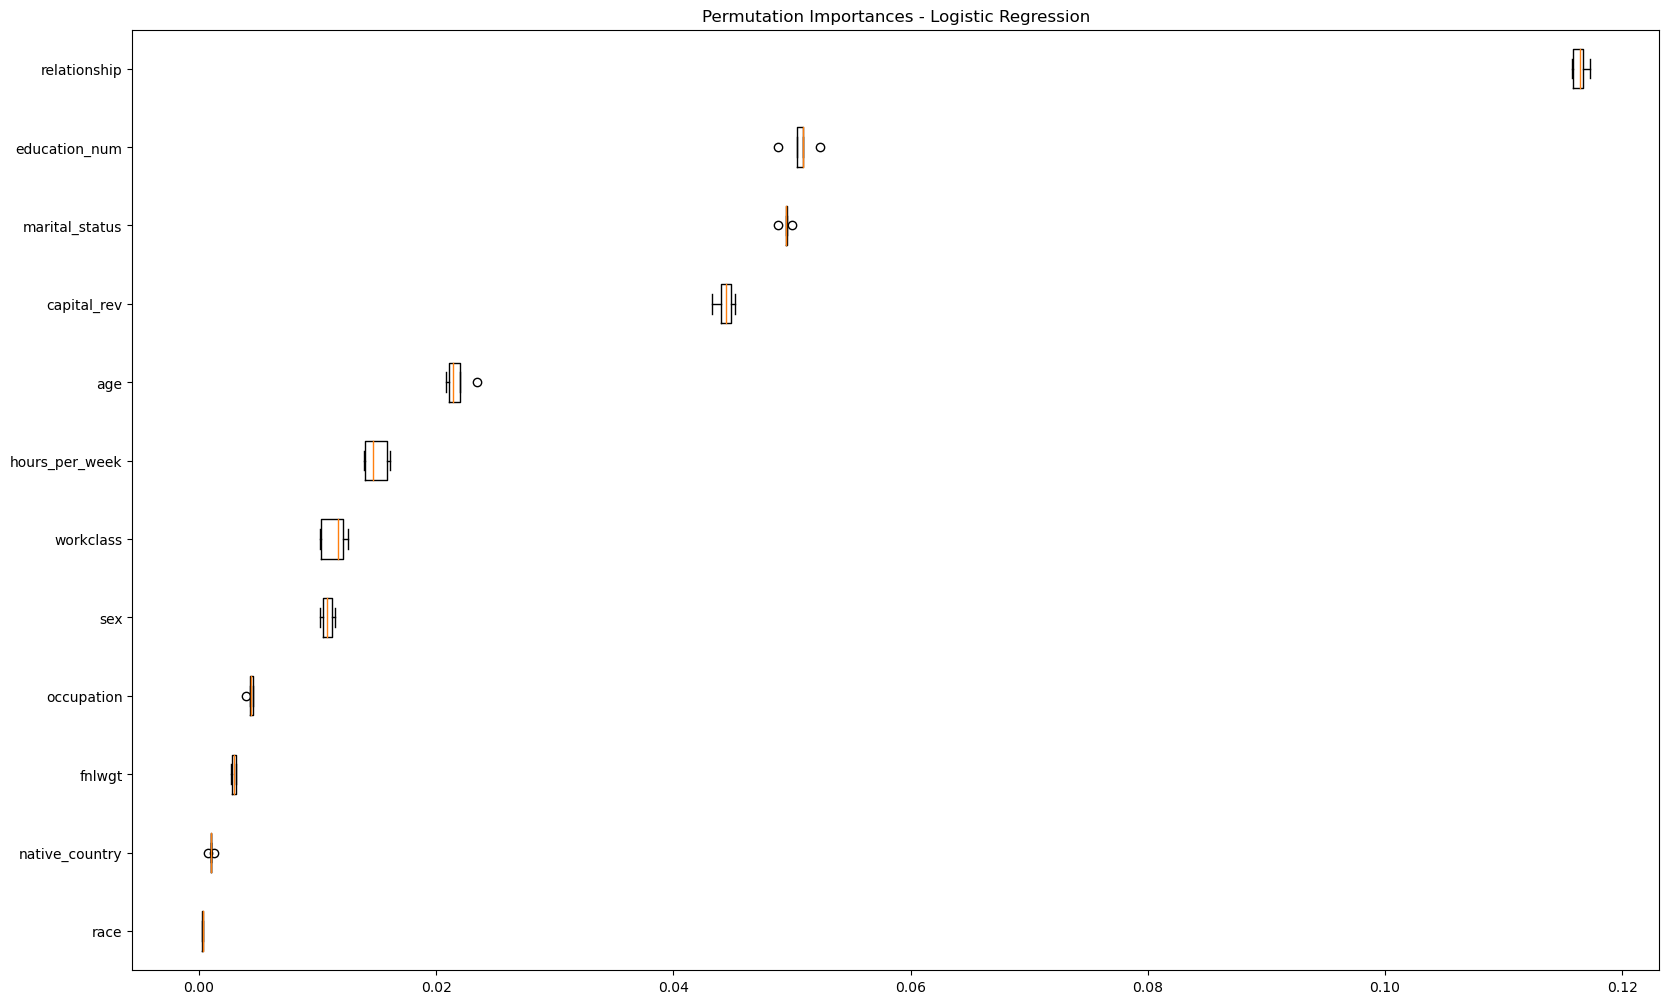

In [94]:
visualize_feature_importance(dt_fi,"Logistic Regression")

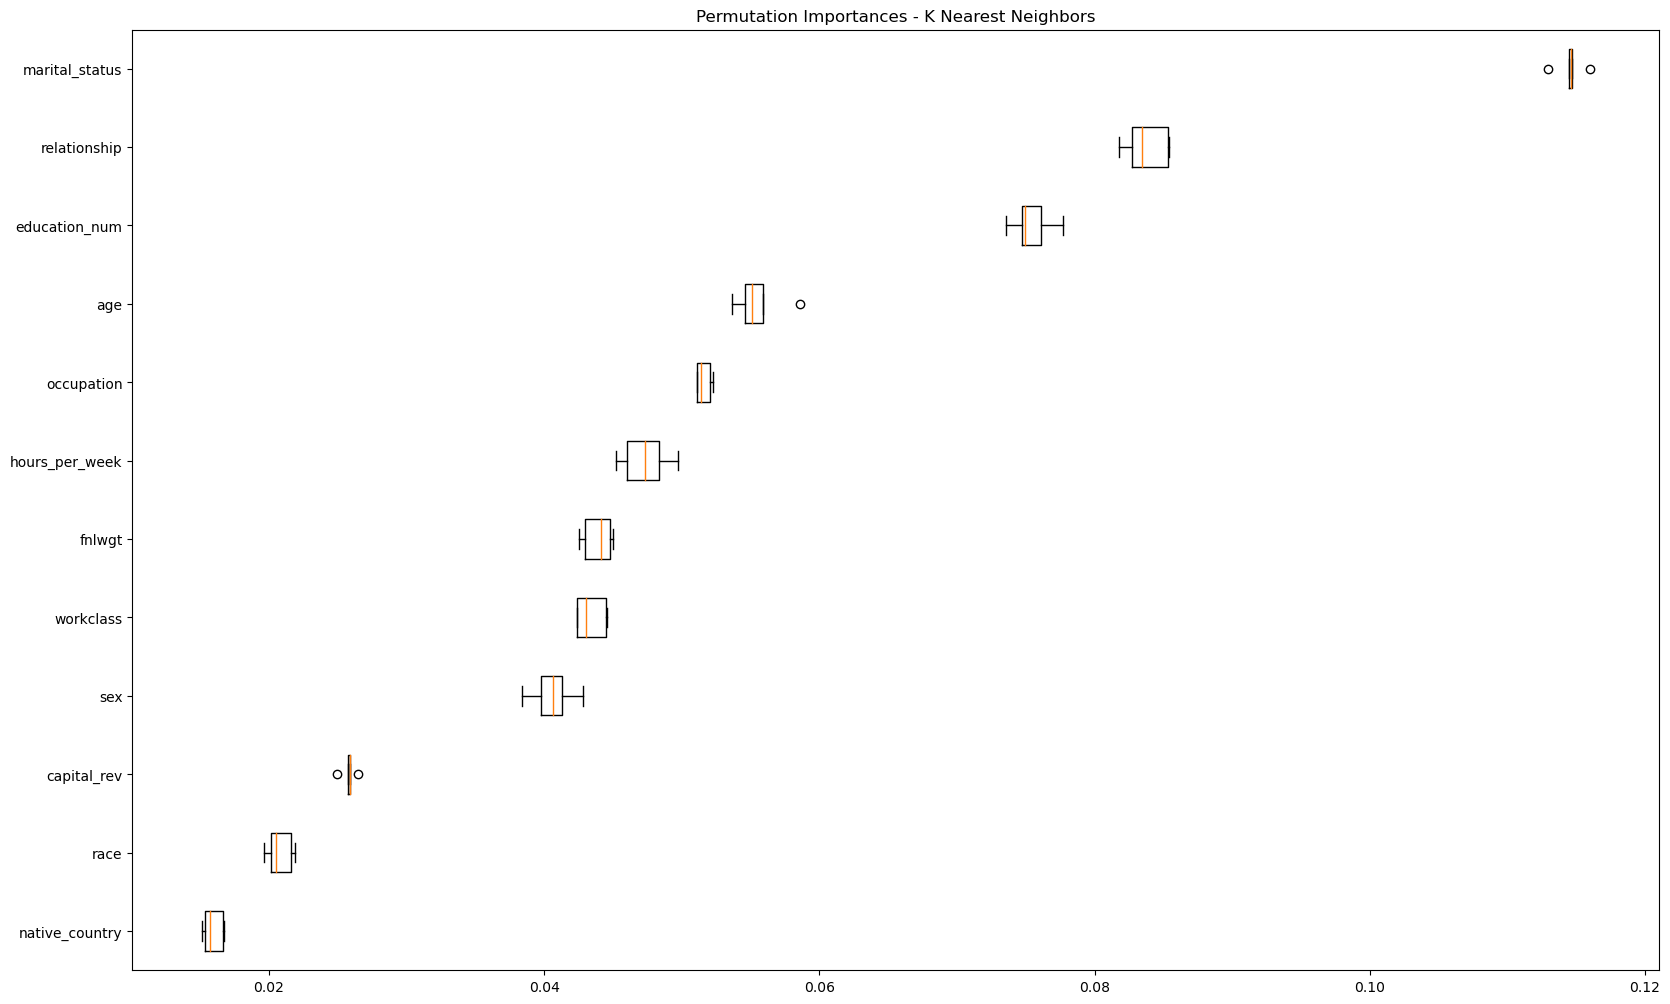

In [95]:
visualize_feature_importance(knn_fi,"K Nearest Neighbors")

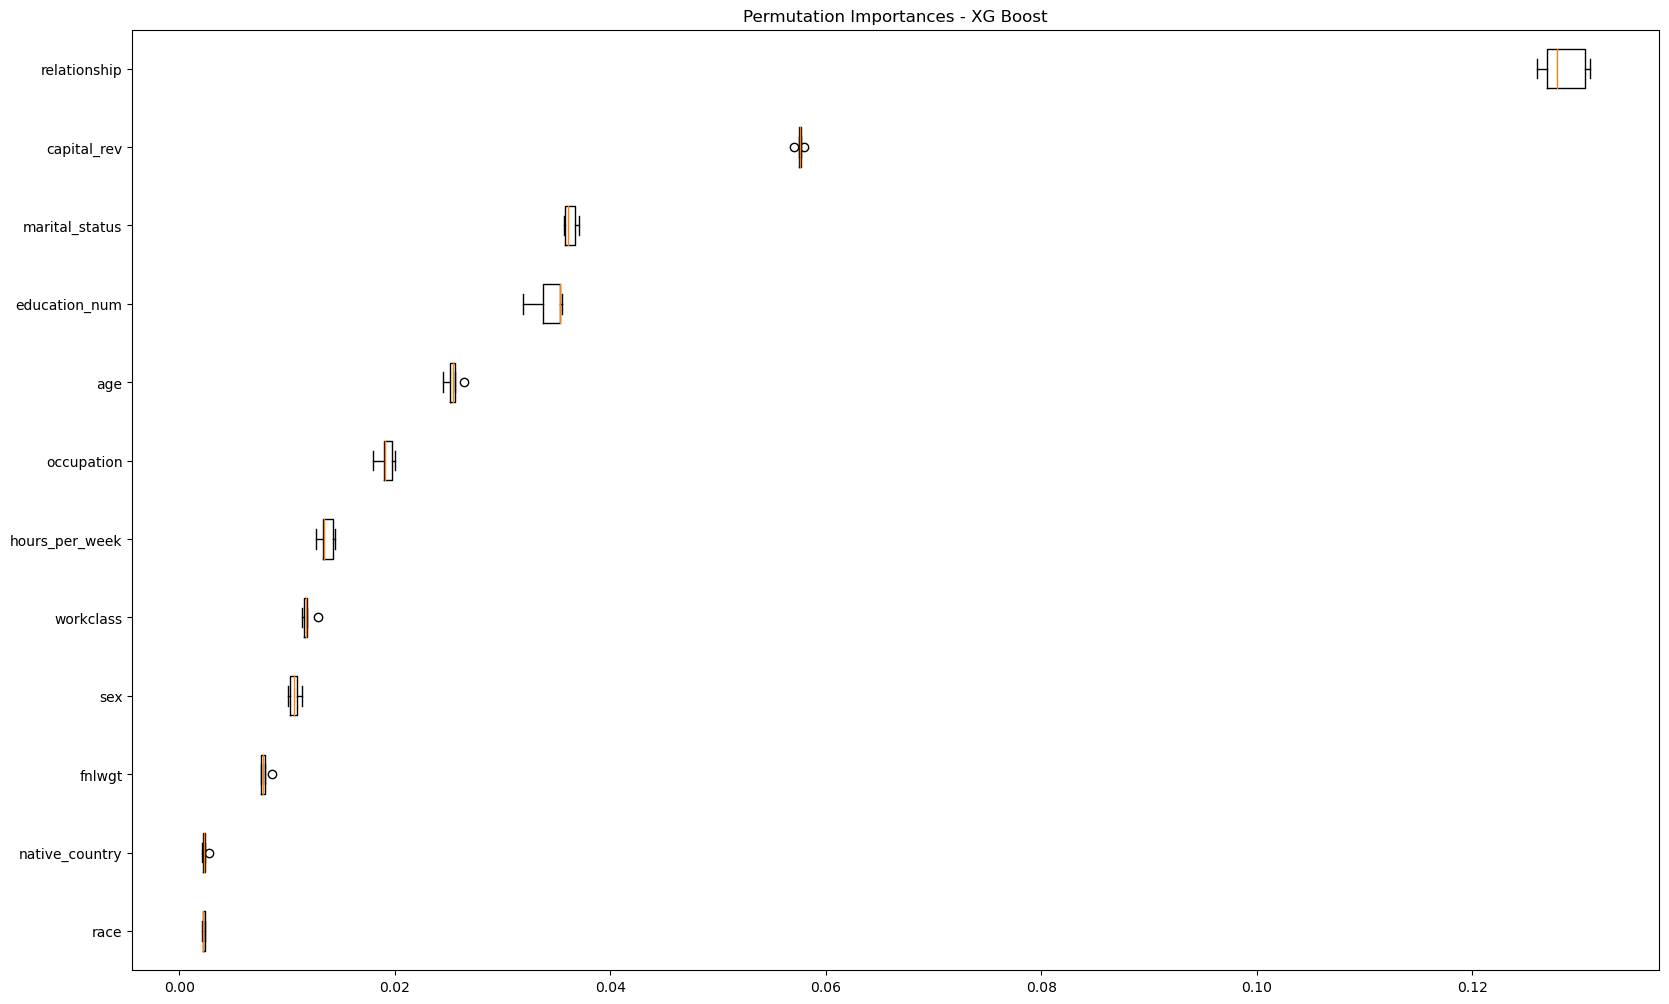

In [96]:
visualize_feature_importance(xgb_fi,"XG Boost")

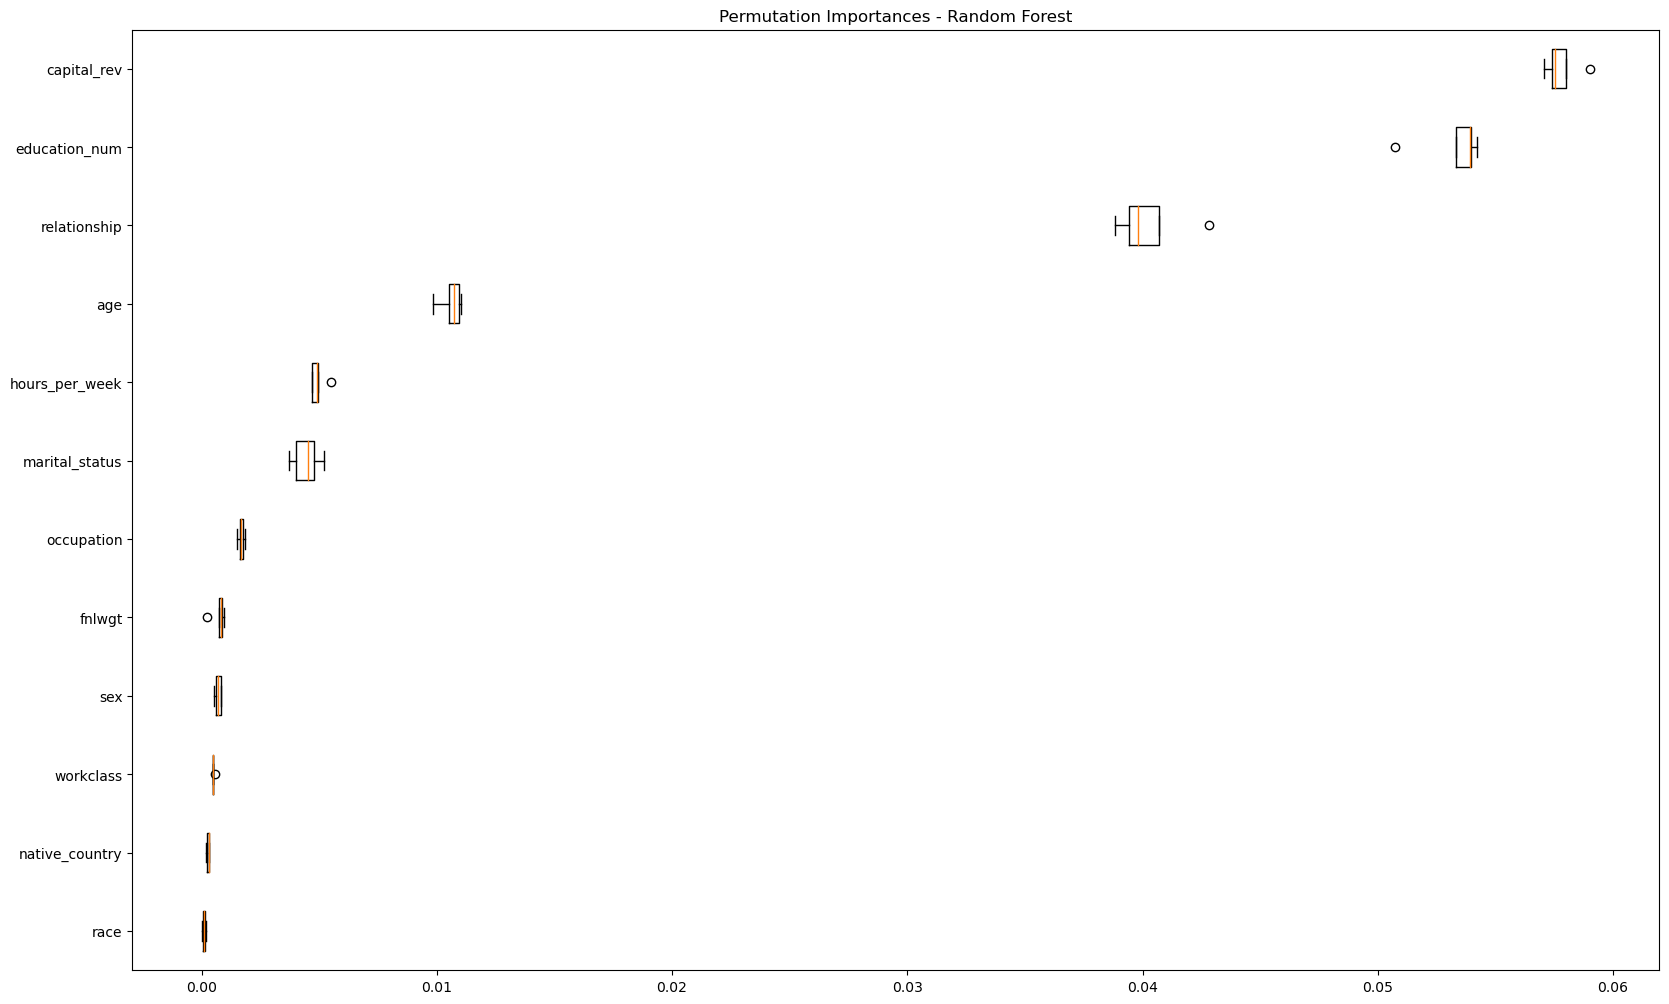

In [97]:
visualize_feature_importance(rf_fi,"Random Forest")

## Model performance comparison

In this section, the best models will be compared agains each other, on the same test sets and with the same cross validation method. All results will be gathered and presented on bar charts regarding accuracy, precision, recall, F1 score and ROC curve.

C:\Users\apobi\AppData\Local\Temp\ipykernel_10916\2431622565.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics.sort_values(by='accuracy', ascending=False, inplace=True)


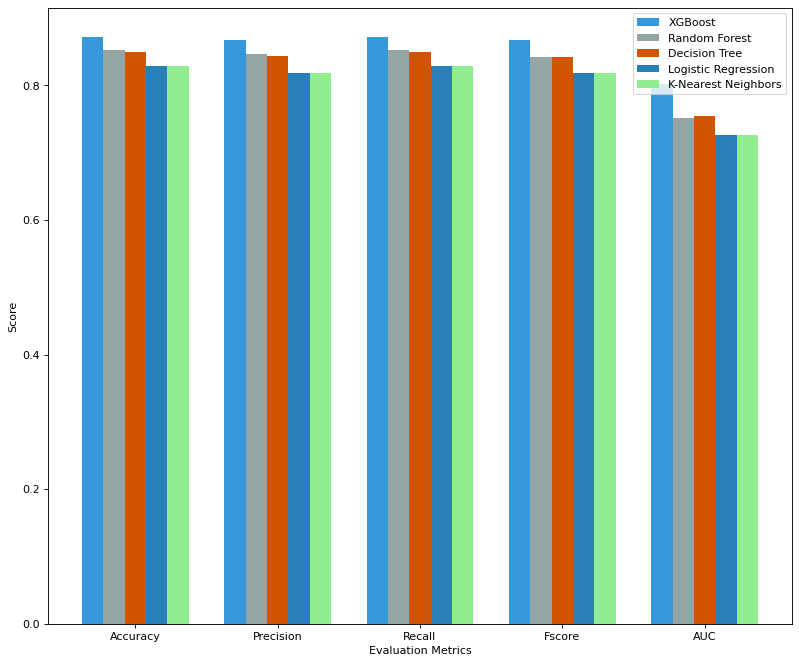

In [98]:
x = np.arange(5)
metrics.sort_values(by='accuracy', ascending=False, inplace=True)
xgb_scores = metrics.iloc[0, 1:].values
rf_scores = metrics.iloc[1, 1:].values
dt_scores = metrics.iloc[2, 1:].values
lr_scores = metrics.iloc[3, 1:].values
knn_scores = metrics.iloc[3, 1:].values
width = 0.15
figure(figsize=(12, 10), dpi=80)
plt.bar(x-0.3, xgb_scores, width, color='#3498db')
plt.bar(x-0.15, rf_scores, width, color='#95a5a6')
plt.bar(x, dt_scores, width, color='#d35400')
plt.bar(x+0.15, lr_scores, width, color='#2980b9')
plt.bar(x+0.3, knn_scores, width, color='#90EE90')
plt.xticks(x, ['Accuracy', 'Precision', 'Recall', 'Fscore', 'AUC'])
plt.xlabel("Evaluation Metrics")
plt.ylabel("Score")
plt.legend(["XGBoost", "Random Forest", "Decision Tree", "Logistic Regression", "K-Nearest Neighbors"])
plt.show()

As shown on the plot, XGBoost is the best model across all algorithm types according to all metrics. <br> Next - Random Forest and Decision Trees gave similar outcomes, with a slight advantage to Random Forest side, only in terms of AUC the Decision Tree was better. 
<br> On the 4th and 5th place were claimed by Linear Regression and K-Nearest Neighbors - both achieving very similar results.

In [99]:
roc_params.sort_values(by='auc', ascending=False, inplace=True)
roc_params

,model,tpr,fpr,auc
0,XG Boost,"[0.0, 0.6620535714285715, 1.0]","[0.0, 0.059161147902869755, 1.0]",0.801446
0,Decision Tree,"[0.0, 0.5638392857142858, 1.0]","[0.0, 0.055334805003679176, 1.0]",0.754252
0,Random Forest,"[0.0, 0.5508928571428572, 1.0]","[0.0, 0.04856512141280353, 1.0]",0.751164
0,K Nearest Neighbors,"[0.0, 0.5825892857142857, 1.0]","[0.0, 0.09963208241353937, 1.0]",0.741479
0,Logistic Regression,"[0.0, 0.5258928571428572, 1.0]","[0.0, 0.07211184694628403, 1.0]",0.726891


In [100]:
model_names = []
for i in range(len(roc_params)):
    model_names.append(roc_params.iloc[i][0])
colors = ["b","g","r","y","m"]

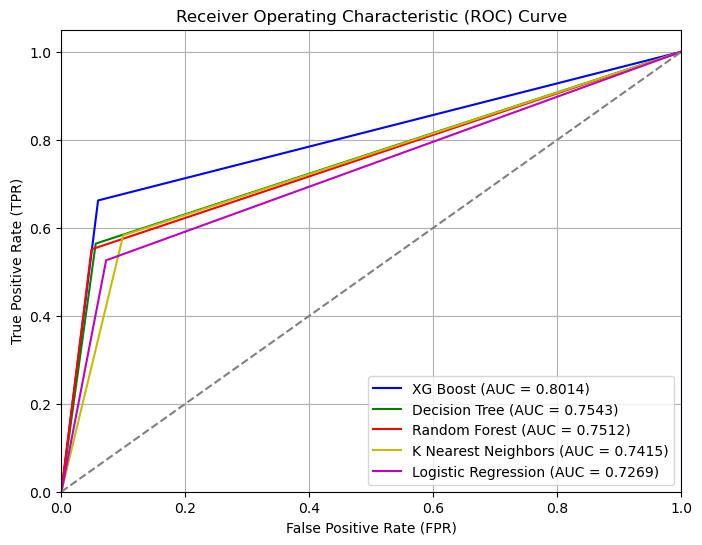

In [101]:
plt.figure(figsize=(8, 6))
for i in range(5):
    plt.plot(roc_params.iloc[i][2], 
             roc_params.iloc[i][1], 
             color = colors[i], 
             label=f'{model_names[i]} (AUC = {roc_params.iloc[i][3]:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

As before, the ROC of XG Boost (blue) is on the top, so the model performed best. <br>
The curves of Decision Tree and Random Forest are very close to each other, right above K Nearest Neighbors.
<br> Logistic Regression lays at the bottom.
<br> Overall, there is a significant difference between XG Boost performance and the rest of models.

## Summary

### Model selection

To sum up, in terms of the best accuracy ensemble methods seem to perform better than individual ones. Model, that proved to be most accurate is XG Boost. However, this model is not so interpretable, as decision trees and logistic regression. In this approach, we focused on getting the best prediction power, so the XG Boost model is the final choice.

### Key Findings

##### Most models calculation point out that variables that stand out in importance are:
<li>Relationship - information weather the person is married, not in family, etc.</li>
<li>Education - level of education aquired,</li>
<li>Capital revenue - difference between capital gain and loss,</li>
<li>Marital status - whether person is married, divorced, widowed, etc. </li>   
<br>Variables that have the least impact on target variable are race and native country.

### Next steps

To enhance model potential, the ensemble methods can be applied to well trained advanced estimator, to check if this combination brings any better results. However this approach require a lot of computing power and could not be performed in this analysis.
<br>Addition of more diversified data could also be the next part of exploration, as over 90% of the data come from the US-born individuals.
<br>Moreover, after implementing chosen models may bring next points to analyse, as data tend to behave different over time and some of variables may prove to be very significant in terms of prediction.